In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import logging
import argparse 
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from itertools import product
from scipy.spatial import Delaunay

# truth PF

# Code

In [2]:
from tqdm import trange

In [3]:
import functions_hv_grad_3d

In [4]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv

In [5]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv


def evaluate_hv(soluong, start, end, net, ref_point, Problem):
    #print('Evaluate')
    results = []
    net.eval()
    # loss1 = toy_loss_1
    # loss2 = toy_loss_2
    # loss3 = toy_loss_3
    angles = np.linspace(start, end, soluong, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    # rays = np.c_[x, y]
    rays = circle_points(soluong, dim=2)
    # min_penalty = 999
    for i in range(soluong):
        ray = rays[i]
        ray /= ray.sum()
        ray = torch.from_numpy(
            ray.astype(np.float32).flatten()
        ).to(device)

        # weights = hnet(ray)
        output = net(ray)[0]
        # l1 = loss1(output,a)
        # l2 = loss2(output,b)
        # l3 = loss3(output,b)
        Loss_list = Problem._evaluate(output)
        Loss_list = [i for i in Loss_list]
        loss_batch = torch.stack(Loss_list).detach().cpu().numpy()
        loss_batch = np.array(loss_batch)
        #loss_mean = np.mean(loss_batch, axis=0)
        # penalty = np.sum(rays[i].astype(np.float32).flatten() * loss_batch) / (np.sqrt(np.sum(loss_batch ** 2)))
        # if penalty < min_penalty:
            # min_penalty = penalty
        results.append(loss_batch)

    results = np.array(results, dtype='float32')
    #print(results)
    return compute_hv(results.T, ref_point), results

In [6]:
def evenly_dist_weights(num_weights, dim):
    return [ret for ret in product(
        np.linspace(0.0, 1.0, num_weights), repeat=dim) if
            round(sum(ret), 3) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

In [51]:
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv') != -1:
        xavier(m.weight.data)
        xavier(m.bias.data)

class FullyConnected(nn.Module):
    def __init__(self, dim,n_task=2,out_dim=10, **kwargs):
        super().__init__()
        self.tasks = n_task
        self.MLP = nn.Sequential(
            nn.Linear(n_task, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),

        )
        self.f = nn.Sequential(
            nn.Linear(dim[0], 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
        )
        self.w = nn.Linear(100, 100)
        self.b = nn.Linear(100, 100)
        for j in range(self.tasks):
            setattr(self, f"task_{j}_weights", nn.Linear(100, out_dim))

    def forward(self,alpha):
        # print('alpha:', alpha)
        x = torch.ones([1, 1], dtype=torch.float32).to(device)
        feature = self.MLP(alpha)
        x = self.f(x)
        x = self.w(feature) * x + self.b(feature)
        output = []
        for j in range(self.tasks):
            output.append(torch.sigmoid(getattr(self, f"task_{j}_weights")(x)))
        # print('output:', output)
        return output

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [46]:
class ZDT3:
    def __init__(self, n_var=2, n_obj=2):
        self.n_obj = n_obj
        self.n_var= n_var
    def _evaluate(self, x):
        out = {}
        
        f1 = torch.mean(torch.cos(x[0, 0])**2) + 0.2

        f2 = torch.mean(1.3+torch.sin(x[0, 1])**2-
                     torch.cos(x[0, 0])-0.1*torch.sin(22*torch.pi*torch.cos(x[0, 0])**2)**5) # -0.5
        out["F"] = torch.column_stack([f1, f2])
        return out["F"][0]
class Lx:
    def __init__(self, n_var=2, n_obj=2):
        self.n_obj = n_obj
        self.n_var= n_var  
    def _evaluate(self, x):
        out = {}
        d = x.shape[1]
        d = torch.from_numpy(np.array(d, dtype='float32'))
        f1 = torch.mean(1-torch.exp(-torch.norm(x-1/torch.sqrt(d), p=2)))

        f2 = torch.mean(1-torch.exp(-torch.norm(x+1/torch.sqrt(d), p=2)))
        out["F"] = torch.column_stack([f1, f2])
        return out["F"][0]
    
class Nasbench201:
    _max_hv = 8.06987476348877
    discrete = True
    def __init__(self):
        self.dim = 6
        self.n_obj = 2
        self.n_var = 6
        bounds = [(0.0, 0.99999)] * self.dim

        self.bounds = torch.tensor(bounds, dtype=torch.float).transpose(-1, -2)

        # with open('nasbench201_std_normalized_data.pt', 'rb') as f:
        self.dataset = torch.load('nasbench201_normalized_data.pth')

    def _evaluate(self, x):
        out ={}
        x = x.tolist()
        for i in range(len(x)):
            for j in range(len(x[i])):
                if 0 <= x[i][j] < 0.2:
                    x[i][j] = 0
                elif 0.2 <= x[i][j] < 0.4:
                    x[i][j] = 1
                elif 0.4 <= x[i][j] < 0.6:
                    x[i][j] = 2
                elif 0.6 <= x[i][j] < 0.8:
                    x[i][j] = 3
                else:
                    x[i][j] = 4
        x = torch.tensor([x], dtype=torch.int32).cuda()
        # print(str(x))
        res = []
        for arch in x:
            res.append([self.dataset[str(arch)][0][0].to(torch.float32), self.dataset[str(arch)][0][1].to(torch.float32)])
        out["F"] = torch.column_stack([res[0][0] / 8,res[0][1]])
        
        return out["F"][0]

In [10]:
import random


def set_logger():
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO
    )


def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [11]:
set_logger()

In [12]:
class parse_arg():
    def __init__(self):
        pass


args = parse_arg()
args.no_cuda = False
args.gpus = '0'

In [13]:
def get_device(no_cuda=False, gpus='0'):
    return torch.device(f"cuda:{gpus}" if torch.cuda.is_available() and not no_cuda else "cpu")


device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
#device=get_device(no_cuda=True)

In [14]:
from functions_evaluation import fastNonDominatedSort

In [15]:
import copy
from utils import num_parameters, circle_points
from functions_hv_python3 import HyperVolume

In [51]:
a = np.random.rand(2,3)
a

array([[0.27000797, 0.73519402, 0.96218855],
       [0.24875314, 0.57615733, 0.59204193]])

# Trainer

In [16]:
from pymoo.factory import get_reference_directions

In [17]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv
import pymc as pm
from neuralgas import GraphNeuralGas

2023-07-31 16:10:13,609 - pytensor.tensor.blas - WARNING - Using NumPy C-API based implementation for BLAS functions.


In [47]:
from utils import num_parameters, circle_points
import copy
def train(device: torch.device, hidden_dim: int, lr: float, wd: float, epochs: int, alpha: float, 
          hesophat: float, cfg,a,b,c, ref, method, Problem):
    training = []
    dim = list((1, ))
    # dim[0] = dim[0] + 2
    net = FullyConnected(dim, out_dim=Problem.n_var)
    # net.apply(weights_init)
    # model = FullyConnected(dim)
    # net = Upsampler(model).cuda()
    # net = Upsampler(model).cuda()
    # net = Toy_Hypernetwork(ray_hidden_dim=hidden_dim, n_tasks=1)
    best_hv = 0
    
    logging.info(f"HN size: {count_parameters(net)}")

    net = net.to(device)
    
    # loss1 = toy_loss_1
    # loss2 = toy_loss_2
    # loss3 = toy_loss_3

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    start = 0.
    end = np.pi / 2
    dem = 0
    epoch_iter = trange(epochs)
    Result = []
    Solution = []
    MCMC = False
    stop = 0
    hv = 0
    best_net = None
    Rays = circle_points(101, dim=2)
    net.train()
    Alpha = []
    n_components = 4
    for epoch in epoch_iter:
        dem += 1
        optimizer.zero_grad()
        p_ray = True
        loss_torch_per_sample = []
        loss_numpy_per_sample = []
        loss_per_sample = []
        weights = []
        outputs = []
        rays = []
        penalty = []
        prob = np.random.rand()
        if MCMC and epoch>100:
            # if np.random.rand() < 0.95:
            if method=='mcmc':
                with pm.Model() as mo:
                    w = [dataframe['mean'][f'w[{i}]'] for i in range(n_components)]
                    p = [[dataframe['mean'][f'p{i+1}[0]'], dataframe['mean'][f'p{i+1}[1]']] 
                         for i in range(n_components)]
                    x = DirichletMixture('x', w=w,
                                         p=p, comp_shape=(n_components, 2))
                x = pm.sample_prior_predictive(samples=1, model=mo)
                ray = x['prior']['x'].values[0]

            else:
                ray = np.random.dirichlet(alpha, 1).astype(np.float32)
        else:
            ray = Rays[epoch]
        ray /= np.sum(ray)
        ray = ray.astype(np.float32)
        rays= torch.from_numpy(
            ray.flatten()).to(device)
        outputs = net(rays)[0]
        Loss_list = Problem._evaluate(outputs)
        Loss_list = [i for i in Loss_list]
        loss_per_sample = torch.stack(Loss_list)
        Solution.append(loss_per_sample.cpu().detach().numpy().tolist())

        if stop == 2:
            print('ending epoch:', epoch)
            break
            
        if (epoch % 50 ==0 and epoch>=100) or epoch==100:
            HV, result = evaluate_hv(soluong=100, start= 0., end=np.pi / 2, net=net, ref_point=ref,Problem=Problem)

            print('result:', result)
            MCMC = True
            used_data = []
            UU_ = []
            div = np.sum(result, 1)
            result[:,0] = result[:,0] / div
            result[:, 1] = result[:,1] / div
            # Data = np.concatenate([result, np.array(Solution)],axis=0)
            Data = np.array(Solution)
            Data = np.around(Data, 6)
            Data = np.unique(Data, axis=0)
            rank, front = fast_non_dominated_sort(Data)
            for n, f in enumerate(front[:-1]):
                if len(used_data) + len(f) > round(len(Solution)*0.2):
                    pop = [Data[p] for p in f]
                    selected_idx = select_best_individuals(np.array(pop).T, round(len(Solution)*0.2)-len(used_data))
                    for idx in selected_idx:
                        used_data.append(pop[idx] / sum(pop[idx]))
                        UU_.append(pop[idx])
                else:
                    for idx in f:
                        used_data.append(Data[idx] / np.sum(Data[idx]))
                        UU_.append(Data[idx])

            fig = plt.figure(figsize=(12, 12))
            ax = fig.add_subplot(111)
            ax.scatter(np.array(Solution)[:,0], np.array(Solution)[:,1], color='red')
            ax.set_xbound(0,1.5)
            ax.set_ybound(0,1.5)
            plt.show()
            with pm.Model(coords={"test_event_dim": range(len(used_data)), "test_support_dim": range(2)}) as model:
                w = pm.Dirichlet('w', a=np.ones(n_components))  
                p1 = pm.Normal("p1",sigma=5, dims=("test_support_dim",)).exp()
                p2 = pm.Normal("p2",sigma=5, dims=("test_support_dim",)).exp()
                p3 = pm.Normal("p3",sigma=5, dims=("test_support_dim",)).exp()
                p4 = pm.Normal("p4",sigma=5, dims=("test_support_dim",)).exp()
                y = DirichletMixture('y', w=w, p=[p1, p2, p3, p4], observed=np.array(used_data), comp_shape=(n_components, 2))
                if method == 'mcmc':
                    step = pm.Metropolis()
                    trace = pm.sample(10000, cores=2, step=step)
                    dataframe = az.summary(trace)
                    print("ray:", np.exp(dataframe['mean']))
            if HV > best_hv:
                print('HV:', HV)
                best_net = copy.deepcopy(net)
                best_hv = HV
                stop = 0
                best_trace = trace
            else:
                stop += 1
        z = torch.ones(loss_per_sample.shape).cuda() * 0.0
        
        d1 = torch.dist(loss_per_sample, z) * (rays.dot(loss_per_sample)/
                                                            (torch.linalg.norm(rays) * torch.linalg.norm(loss_per_sample)))
        d2 = torch.sqrt(torch.dist(loss_per_sample, z)**2 - d1**2)
        tch_reward  = hesophat* d1 + (1-hesophat) * d2
   
        tch_reward.requires_grad_(True)
        tch_reward.backward()
        optimizer.step()

    return best_net, best_trace, Alpha

In [19]:
class DirichletMixture:

    def __new__(cls, name, w, p=None, comp_shape=(), **kwargs):
        
        return pm.Mixture(name, w, pm.Dirichlet.dist(a=p, shape=comp_shape), **kwargs)

    @classmethod
    def dist(cls, w, p=None, comp_shape=(), **kwargs):

        return pm.Mixture.dist(w, pm.Dirichlet.dist(a=p, shape=comp_shape), **kwargs)

# Test

In [20]:
unit = np.linspace(0, 1, 6)
n_tasks = 3
vector = [0] * n_tasks
rays_vector = []
rays_vector = get_reference_directions("das-dennis", 3, n_partitions=5).astype(
    np.float32
)

rays_sampling = np.array(rays_vector)
rays_vector_2 = np.delete(rays_sampling, -1, axis=1)
tri = Delaunay(rays_vector_2)
partition = tri.simplices
partition = partition.astype(np.int32)

/tmp/ipykernel_710790/743211191.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_reference_directions. (Please use `from pymoo.util.ref_dirs import get_reference_directions`)
  rays_vector = get_reference_directions("das-dennis", 3, n_partitions=5).astype(


In [21]:
def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [22]:
from functions_evaluation import fast_non_dominated_sort
class HypPar(): 
    def __init__(self,data,n): 
        self.n = n
        self.v = data
        self.d = data.shape[0]
    def sample(self): 
        i = np.random.randint(low=0,high=self.n)
        return self.v[:,i]

    def plot(self): 
        if self.d==3:
            ax = plt.axes(projection ="3d");
        else : 
            ax = plt.axes()
        ax.scatter(*self.v, color = "blue",alpha=0.02);
        return ax 
def crowding_distance_sorting(fitness_values):
    num_objectives, num_individuals = fitness_values.shape
    sorted_fitness_indices = np.argsort(fitness_values, axis=1)
    crowding_distance = np.zeros(num_individuals)

    for i in range(num_objectives):
        sorted_fitness_values = fitness_values[i][sorted_fitness_indices[i]]
        crowding_distance[sorted_fitness_indices[i][0]] = np.inf
        crowding_distance[sorted_fitness_indices[i][-1]] = np.inf
        for j in range(1, num_individuals-1):
            crowding_distance[sorted_fitness_indices[i][j]] += (
                sorted_fitness_values[j+1] - sorted_fitness_values[j-1])
            
    return crowding_distance


def select_best_individuals(fitness_values,n):
    num_objectives, num_individuals = fitness_values.shape
    crowding_distance = crowding_distance_sorting(fitness_values)
    sorted_indices = np.argsort(crowding_distance)[::-1]
    best_individuals_indices = sorted_indices[:n]
    return best_individuals_indices

In [54]:
cfg = {}
cfg["ref_point"] = (2, 2, 2)
cfg["n_mo_obj"] = 3
cfg["n_mo_sol"] = partition.shape[0]
device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
hidden_dim = 100
lr = 1e-2
wd = 0.
epochs = 1000
alpha = 1.
cfg = cfg
head = cfg["n_mo_sol"]
hesophat = 0.01  #lamda
n_mo_obj = cfg["n_mo_obj"]
n_mo_sol = cfg["n_mo_sol"]
ref_point = cfg["ref_point"]
method = "4_MH"
ref=[6,6]
a=1
b=1
c=1
method = 'mcmc'
_Problem = Nasbench201()

  7%|▋         | 66/1000 [00:00<00:01, 656.95it/s]

result: [[0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16216215]
 [0.08254509 0.16

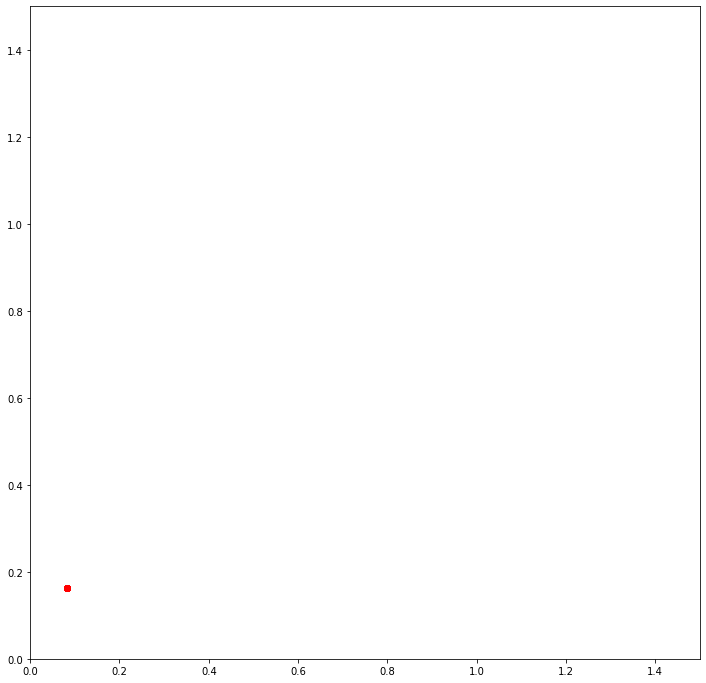

 10%|█         | 100/1000 [00:05<00:45, 19.96it/s]


KeyboardInterrupt: 

In [55]:
import arviz as az
from pymc3.tuning import find_MAP
set_seed(0)
net, trace, Alpha = train(device = get_device(no_cuda=args.no_cuda, gpus=args.gpus), hidden_dim=100,
                  lr=1e-2, wd=0., epochs=epochs, alpha=1, cfg= cfg, hesophat=hesophat,a=a, b=b,c=c, ref=ref,method=method, Problem=_Problem);

In [25]:
results = []

rays = circle_points(1000, dim=2)

for i in range(len(rays)):
    ray = rays[i]

    ray /= ray.sum()
    ray = ray.astype(np.float32)
    ray = torch.from_numpy(
        ray.flatten()
    ).to(device)

    # weights = hnet(ray)"
    output = net(ray)[0]
    
    # L = Lx(n_var=100, n_obj=2)
    L = ZDT3(n_var=2,n_obj=2)
    results.append(L._evaluate(output))

In [26]:
results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy()] for i in results]
results = np.array(results, dtype='float32')
from functions_evaluation import fast_non_dominated_sort

rank, front = fast_non_dominated_sort(results)
used_data = []
for n, f in enumerate(front[:-2]):
    for idx in f:
        used_data.append(results[idx])
    break
results = np.array(used_data)

In [127]:
results

array([[0.8723451 , 0.08084059]], dtype=float32)

In [47]:
p='lx'
np.save(f"front/Toy_ddps_{p}"+".npy", results)

In [1]:
import matplotlib.collections
import mpl_toolkits.mplot3d as a3
import matplotlib as mpl
import scipy as sp

In [68]:
results = np.load(f"front/Toy_ddps_{p}"+".npy")

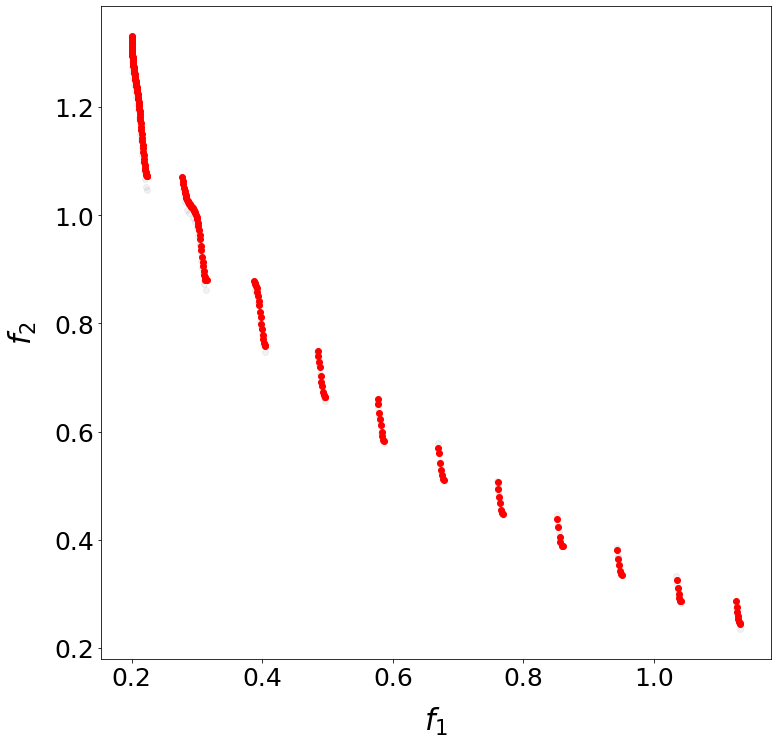

In [27]:
fig = plt.figure(figsize=(12, 12))
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
import matplotlib.pylab as pylab
from matplotlib.pyplot import MultipleLocator
params={
    'axes.labelsize': '12',         #轴上字
    'xtick.labelsize':'12',        #轴图例
    'ytick.labelsize':'12',           #轴图例
    'lines.linewidth':2 ,              #线宽
    'legend.fontsize': '25',          #图例大小
    'figure.figsize'   : '8, 6'    # set figure size,长12，宽9
}
pylab.rcParams.update(params)            #set figure parameter
ax = fig.add_subplot(111)
#ax.dist = 30
ax.azim = 60
stride=1
u = np.linspace(0, np.pi/2, 200)
v = np.linspace(0, np.pi/2, 200)
r = 1
x = r*np.outer(np.cos(u), np.sin(v))
y = r*np.outer(np.sin(u), np.sin(v))
pf = np.load('toy3_truth.npy')
ax.scatter(pf[:, 0], pf[:, 1], color='gray',alpha=0.1)

ax.scatter(results[:, 0], results[:, 1],color='r', zorder=10)


ax.set_xlabel(r'$f_{1}$', fontsize=30, labelpad=15)
ax.set_ylabel(r'$f_{2}$', fontsize=30,labelpad=15)

ax.tick_params(axis='x',labelsize=25)
ax.tick_params(axis='y',labelsize=25)

# plt.savefig('newfig/dtlz4_cosmos_1_1.png',dpi=400)

In [44]:
# np.load('Toy_2_truth.npy')

2023-04-16 12:21:29,901 - arviz.data.io_pymc3_3x - ERROR - Got error No model on context stack. trying to find log_likelihood in translation.
/root/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
2023-04-16 12:21:31,300 - arviz.data.io_pymc3_3x - ERROR - Got error No model on context stack. trying to find log_likelihood in translation.


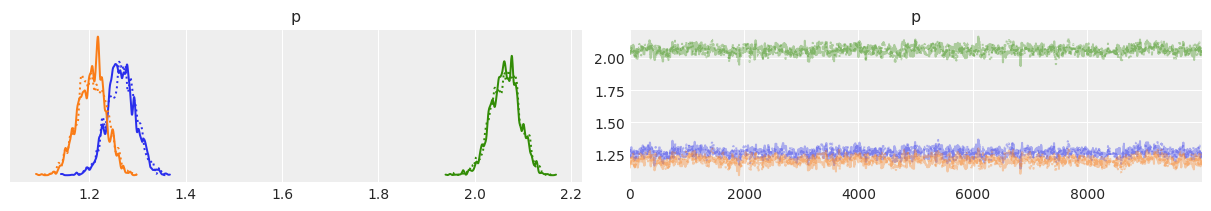

In [78]:
import arviz as az
az.style.use("arviz-darkgrid")
az.plot_trace(trace)
plt.savefig('fig/mcmc_dtlz4_10.png', dpi=500)

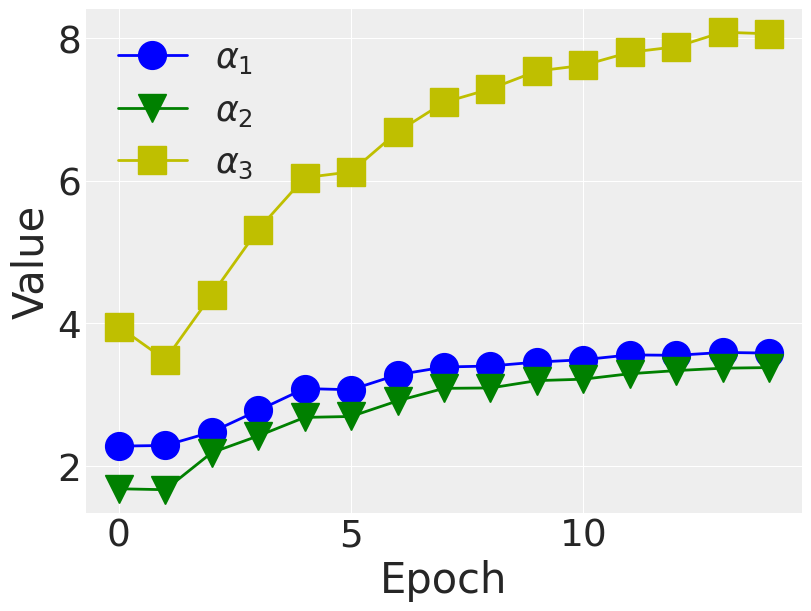

In [80]:
import matplotlib.pylab as pylab
params={
    'axes.labelsize': '30',         #轴上字
    'xtick.labelsize':'27',        #轴图例
    'ytick.labelsize':'27',           #轴图例
    'lines.linewidth':2 ,              #线宽
    'legend.fontsize': '25',          #图例大小
    'figure.figsize'   : '8, 6'    # set figure size,长12，宽9
}
pylab.rcParams.update(params)            #set figure parameter
plt.plot(range(len(Alpha)),np.array(Alpha)[:,0],'bo-',label=r'$\alpha_{1}$',markersize=20) # in 'bo-', b is blue, o is O marker, - is solid line and so on
plt.plot(range(len(Alpha)),np.array(Alpha)[:,1],'gv-',label=r'$\alpha_{2}$',markersize=20)
plt.plot(range(len(Alpha)),np.array(Alpha)[:,2],'ys-',label=r'$\alpha_{3}$',markersize=20)
plt.legend(loc="best")  #set legend location
plt.ylabel('Value')   # set ystick label
plt.xlabel('Epoch')  # set xstck label
plt.savefig('fig/mcmc_dtlz4_alpha_10.png', dpi=500)
# plt.plot(range(len(Alpha)), np.array(Alpha)[:,0], )
    
# for a1, a2, a3 in Alpha:
# Alpha